In [4]:
%load_ext autoreload
%autoreload 2

In [48]:
import os
import time
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

import torch

from env import Environment
from models import Traider

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

SEED = 1777
np.random.seed(SEED)
torch.manual_seed(SEED)

In [49]:
@dataclass
class Config:

    observation_dim = 80

    num_hidden_layers = 6

    n_actions = 2

    levels = 41

    learning_rate = 0.0003

    epochs_limit = 50

    update_online_model_step = 5
    update_target_model_step = 250

    epsilon = 0.25

    transaction = 100.0

    batch_size = 32

    gamma = 0.5

    memory_limit = 100000

    train_data_path = 'train.data'

    test_data_path = 'test.data'

    device = 'cuda:0'

In [50]:
def test(environment, model, cfg):
    
    done = False
    
    state = environment.reset()
    
    total_reward = 0
    
    rewards = []

    with torch.no_grad():
    
        while not done:
            
            state_tensor = torch.tensor(state).unsqueeze(0).float()
            action = torch.argmax(model(state_tensor)[0]).item()
            
            state, reward, done = environment.step(action, cfg.transaction)
            
            total_reward += reward
            
            rewards.append(total_reward)
    
    return (rewards[-1] - rewards[-125])

In [45]:
def train(environment, online_model, target_model, optimizer, loss_fn, cfg):
    
    for epoch in range(cfg.epochs_limit):
        
        print("epochs: " + str(epoch))
        
        actions_history     = []
        states_history      = []
        next_states_history = []
        rewards_history     = []
        
        done = False
        
        step = 0
        
        state = environment.reset()
        
        epoch_reward = 0
        
        while not done:
            
            step += 1
            
            if cfg.epsilon > np.random.random():
                action = np.random.choice(cfg.n_actions)
            else:
                
                state_tensor = torch.tensor(state).unsqueeze(0).float()
                action = torch.argmax(online_model(state_tensor)[0]).item()
            
            next_state, reward, done = environment.step(action, cfg.transaction) 
            
            epoch_reward += reward
            
            actions_history.append(action)
            states_history.append(state)
            next_states_history.append(next_state)
            rewards_history.append(reward)
            
            state = next_state
            
            if step % cfg.update_online_model_step == 0 and len(rewards_history) > cfg.batch_size:
                
                indices = np.random.choice(range(len(rewards_history)), size = cfg.batch_size)
                
                action_sample     = torch.tensor([actions_history     [i] for i in indices]) 
                state_sample      = torch.tensor([states_history      [i] for i in indices]).float() 
                next_state_sample = torch.tensor([next_states_history [i] for i in indices]).float() 
                rewards_sample    = torch.tensor([rewards_history     [i] for i in indices]).float() 

                with torch.no_grad():
                    
                    out = target_model(next_state_sample)
                    future_rewards = torch.max(out, dim=1)[0] 
                
                updated_q_values = rewards_sample + cfg.gamma * future_rewards

                mask = torch.nn.functional.one_hot(action_sample, cfg.n_actions)

                q_values = online_model(state_sample)
                q_action = torch.sum(q_values * mask, dim=1)
                optimizer.zero_grad()

                loss = loss_fn(updated_q_values, q_action)
                loss.backward()
                optimizer.step()
                
            print(epoch_reward)
        
            if step % cfg.update_target_model_step == 0:
                
                target_model.load_state_dict(online_model.state_dict())
            
            if len(rewards_history) > cfg.memory_limit:
                del actions_history     [:1]
                del states_history      [:1]
                del next_states_history [:1]
                del rewards_history     [:1]
        
        print("train reward: %.2f" % epoch_reward)

In [46]:
cfg = Config()

online_model = Traider(in_dim=cfg.observation_dim, out_dim=cfg.n_actions, num_hidden_layers=cfg.num_hidden_layers)
target_model = Traider(in_dim=cfg.observation_dim, out_dim=cfg.n_actions, num_hidden_layers=cfg.num_hidden_layers)

environment_train = Environment(cfg.train_data_path, cfg.levels, cfg.observation_dim)

environment_test = Environment(cfg.test_data_path, 1, cfg.observation_dim)

loss_fn = torch.nn.HuberLoss()

optimizer = torch.optim.Adam(online_model.parameters(), lr=cfg.learning_rate)

In [47]:
train(environment_train, online_model, target_model, optimizer, loss_fn, cfg)

epochs: 0
0.047640000000000085
1.9077120506040002
1.7025291503835043
2.3190418547119327
7.046615977885402
6.6122183348747985
9.400357879884586
12.81134478862091
17.309198182397708
18.221307781488907
22.236113321244908
19.93654420347503
13.08715416639103
7.457969227221685
5.941561409733558
6.8386259447335584
6.528934124733558
5.222179219733558
4.390086778871558
5.268315634739569
3.338553439487506
7.920368843796229
6.5482809775979485
6.266417477838642
7.392235329955367
8.536056928010478
7.106505258010477
5.6762980755254775
6.2240585069342345
6.139453936934235
3.9295613866622348
4.161854300387098
4.839047605387098
4.270586285387098
5.854830710387098
1.036816294041098
-5.8916229886446105
-2.2990857701088863
-0.0013906593252461796
-2.840010498601949
0.36104729968502447
3.2913376786356183
6.177187937119743
6.392974792119743
7.181265741879743
7.60209120581723
7.6655771380493185
9.290869436165119
9.580236707014352
7.38868976026029
8.851093013025402
9.682990712135854
9.912555457135854
9.9104025

KeyboardInterrupt: 

1332.5606139609567


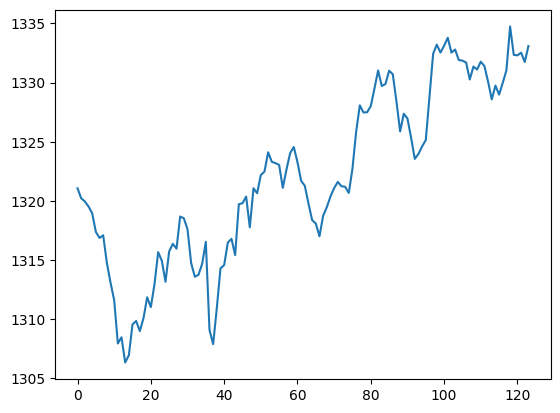

In [8]:
# TODO

done = False

state = environment_test.reset().astype(np.float32)

total_reward = 0

rewards = []
        
while not done:

    state_tensor = tf.convert_to_tensor(state)
    state_tensor = tf.expand_dims(state_tensor, 0)
    
    action = np.argmax(target_model(state_tensor)[0].numpy())
            
    state, reward, done = environment_test.step(action, transaction) # + total_reward)
    
    state = state.astype(np.float32)
            
    total_reward += reward
    
    rewards.append(total_reward)
    
print(total_reward)

plot.plot(rewards[-125:-1])

In [ ]:
#target_model.save("models/model_XX.h5")